# CNN for Pi0 Classification

In this notebook, we train 10 layers deep CNN for particle type classification ($e^-$, $\mu^-$, and $\gamma$) using the workshop dataset.

In [1]:
from __future__ import print_function
from IPython.display import display
import torch, time
import numpy as np

## Defining a network
Let's define our network. The design below consists of 8 convolution layers + 3 fully-connected layers (10 learnable layers). Here is a summary of the graph operations.
* Feature extractor:
    1. Input shape: (N,88,168,2) ... N samples of 88x168 2D images with 2 channels
    2. 2x Convolution layer + BatchNorm + ReLU, 32 filters, kernel size 3x3, stride 1 (default)
    3. 2D max-pooling, kernel size 2, stride 2
    4. 2x Convolution layer + BatchNorm + ReLU, 32 filters, kernel size 3x3, stride 1 (default)
    5. 2D max-pooling, kernel size 2, stride 2
    6. 2x Convolution layer + BatchNorm + ReLU, 64 filters, kernel size 3x3, stride 1 (default)
    7. 2D max-pooling, kernel size 2, stride 2
    8. 2x Convolution layer + BatchNorm + ReLU, 128 filters, kernel size 3x3, stride 1 (default)
* Flattening
    9. 2D average-pooling, kernel size = 2D image spatial dimension at this point (results in length 128 1D array)
* Classifier:
    10. Fully-connected layer + BatchNorm + ReLU, 128 filters
    11. Fully-connected layer + BatchNorm + ReLU, 128 filters
    12. Fully-connected layer, M filters where M = number of classification categories

In [2]:
class CNN(torch.nn.Module):
    
    def __init__(self, num_class):
        
        super(CNN, self).__init__()
        # feature extractor CNN
        self._feature = torch.nn.Sequential(
            torch.nn.Conv2d(2,32,3), torch.nn.BatchNorm2d(32), torch.nn.ReLU(),
            torch.nn.Conv2d(32,32,3), torch.nn.BatchNorm2d(32), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(32,32,3), torch.nn.BatchNorm2d(32), torch.nn.ReLU(),
            torch.nn.Conv2d(32,32,3), torch.nn.BatchNorm2d(32), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(32,64,3), torch.nn.BatchNorm2d(64), torch.nn.ReLU(),
            torch.nn.Conv2d(64,64,3), torch.nn.BatchNorm2d(64), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(64,128,3), torch.nn.BatchNorm2d(128), torch.nn.ReLU(),
            torch.nn.Conv2d(128,128,3), torch.nn.BatchNorm2d(128), torch.nn.ReLU())
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(128,128),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,128),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,num_class)
        )

    def forward(self, x):
        net = self._feature(x)
        net = torch.nn.AvgPool2d(net.size()[2:])(net)
        return self._classifier(net.view(-1,128))


## Defining a train loop
For convenience, define a _BLOB_ class to keep objects together. To a BLOB instance, we attach LeNet, our loss function (`nn.CrossEntropyLoss`), and Adam optimizer algorithm. For analysis purpose, we also include `nn.Softmax`. Finally, we attach data and label place holders.

In [3]:
class BLOB:
    pass
blob=BLOB()
blob.net       = CNN(2).cuda() # construct Lenet for 2 class classification, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

We define 2 functions to be called in the training loop: forward and backward. These functions implement the evaluation of the results, error (loss) definition, and propagation of errors (gradients) back to update the network parameters.

In [4]:
def forward(blob,train=True):
    """
       Args: blob should have attributes, net, criterion, softmax, data, label
       Returns: a dictionary of predicted labels, softmax, loss, and accuracy
    """
    with torch.set_grad_enabled(train):
        # Prediction
        data = torch.as_tensor(blob.data).cuda()#[torch.as_tensor(d).cuda() for d in blob.data]
        data = data.permute(0,3,1,2)
        prediction = blob.net(data)
        # Training
        loss,acc=-1,-1
        if blob.label is not None:
            label = torch.as_tensor(blob.label).type(torch.LongTensor).cuda()#[torch.as_tensor(l).cuda() for l in blob.label]
            label.requires_grad = False
            loss = blob.criterion(prediction,label)
        blob.loss = loss
        
        softmax    = blob.softmax(prediction).cpu().detach().numpy()
        prediction = torch.argmax(prediction,dim=-1)
        accuracy   = (prediction == label).sum().item() / float(prediction.nelement())        
        prediction = prediction.cpu().detach().numpy()
        
        return {'prediction' : prediction,
                'softmax'    : softmax,
                'loss'       : loss.cpu().detach().item(),
                'accuracy'   : accuracy}

def backward(blob):
    blob.optimizer.zero_grad()  # Reset gradients accumulation
    blob.loss.backward()
    blob.optimizer.step()


## Running a train loop 
Let's prepare the data loaders for both train and test datasets. We use the latter to check if the network suffers from overtraining.

In [5]:
# Create data loader
from iotools import loader_factory
DATA_DIRS=['/data/hkml_data/IWCDgrid/varyAll/e-','/data/hkml_data/IWCDgrid/varyAll/pi0']
# for train
def transform(result):
    if result[1] == 3:
        result[1] = 0
#    result[1] -= 1
    return result
    
#train_loader=loader_factory('H5Dataset', batch_size=64, shuffle=True, num_workers=4, data_dirs=DATA_DIRS, flavour='100k.h5', start_fraction=0.0, use_fraction=0.5, transform=transform, energy_min=0, energy_max=500)
# for validation
train_loaders = [loader_factory('H5Dataset', batch_size=64, shuffle=True, num_workers=4, data_dirs=DATA_DIRS, flavour='100k_q80.h5', start_fraction=0.5, use_fraction=0.5, transform=transform, energy_min=0, energy_max=e) for e in range(100,1001,100)]

2514  events selected
5783  events selected
9131  events selected
12429  events selected
15733  events selected
19058  events selected
22342  events selected
25698  events selected
28915  events selected
32225  events selected


In [6]:
#test_loader=loader_factory('H5Dataset', batch_size=200, shuffle=True, num_workers=2, data_dirs=DATA_DIRS, flavour='100k.h5', start_fraction=0.5, use_fraction=0.5, transform=transform, energy_min=0, energy_max=500)
#test_loader2=loader_factory('H5Dataset', batch_size=200, shuffle=True, num_workers=2, data_dirs=DATA_DIRS, flavour='100k.h5', start_fraction=0.5, use_fraction=0.5, transform=transform, energy_min=500, energy_max=1000)
test_loaders = [loader_factory('H5Dataset', batch_size=200, shuffle=True, num_workers=2, data_dirs=DATA_DIRS, flavour='100k_q80.h5', start_fraction=0.0, use_fraction=0.5, transform=transform, energy_min=0, energy_max=e) for e in range(100,1001,100)]


2468  events selected
5731  events selected
9001  events selected
12247  events selected
15641  events selected
19015  events selected
22292  events selected
25664  events selected
29076  events selected
32488  events selected


In [7]:
test_loaders2 = [loader_factory('H5Dataset', batch_size=200, shuffle=True, num_workers=2, data_dirs=DATA_DIRS, flavour='100k_q80.h5', start_fraction=0.0, use_fraction=0.5, transform=transform, energy_min=e-100, energy_max=e) for e in range(100,1001,100)]

2468  events selected
3263  events selected
3270  events selected
3246  events selected
3394  events selected
3374  events selected
3277  events selected
3372  events selected
3412  events selected
3412  events selected


Also import `CSVData` from our utility module, which lets us write train log (accuracy, loss, etc.) in a csv file.

In [8]:
# Import 0) progress bar and 1) data recording utility (into csv file)
from utils import progress_bar, CSVData
blob.train_log, blob.test_log = CSVData('log_train.csv'), CSVData('log_test.csv')

Finally, we're ready to run the training! Let's create a dataloader, write a loop to  call forward and backward.

In [8]:
# Define train period. "epoch" = N image consumption where N is the total number of train samples.
print("15 epochs")
TRAIN_EPOCH=15.0
# Set the network to training mode
blob.net.train()
epoch=0.
iteration=0
# Start training
for iepoch in range(15):
#while epoch < TRAIN_EPOCH:
    iloader = min(iepoch,9)
    print('Epoch',int(epoch+0.5),'Starting @',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # Create a progress bar for this epoch
    from utils import progress_bar
    progress = display(progress_bar(0,len(train_loaders[iloader])),display_id=True)
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loaders[iloader]):
        # Data and label
        blob.data,blob.label = data[0:2]
        # Call forward: make a prediction & measure the average error
        res = forward(blob,True)
        # Call backward: backpropagate error and update weights
        backward(blob)
        # Epoch update
        epoch += 1./len(train_loaders[iloader])
        iteration += 1
        
        #
        # Log/Report
        #
        # Record the current performance on train set
        blob.train_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%10 == 0:
            message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
            progress.update(progress_bar((i+1),len(train_loaders[iloader]),message))
        # more rarely, run validation
        if (i+1)%100 == 0:
            with torch.no_grad():
                blob.net.eval()
                test_data = next(iter(test_loaders[iloader]))
                blob.data,blob.label = test_data[0:2]
                res = forward(blob,False)
                blob.test_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
                blob.test_log.write()
            blob.net.train()
        if epoch >= TRAIN_EPOCH:
            break
    message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
    progress.update(progress_bar((i+1),len(train_loaders[iloader]),message))

blob.test_log.close()
blob.train_log.close()

15 epochs
Epoch 0 Starting @ 2019-04-18 19:42:34


RuntimeError: CUDA out of memory. Tried to allocate 25.00 MiB (GPU 0; 11.17 GiB total capacity; 754.45 MiB already allocated; 14.12 MiB free; 12.05 MiB cached)

## Inspecting the training process
Let's plot the train log for both train and test set.

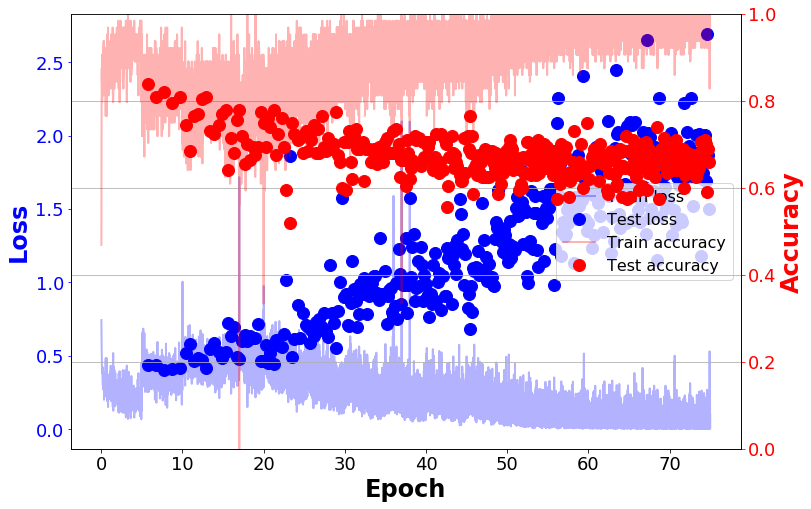

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
test_log  = pd.read_csv(blob.test_log.name)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch, test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Train accuracy', color='r', alpha=0.3)
line22 = ax2.plot(test_log.epoch, test_log.accuracy, marker='o', markersize=12, linestyle='', label='Test accuracy', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

We see the loss is coming down while the accuracy is increasing. These two should be anti-correlated, so this is expected. We also see the network performance on the test dataset (circles) follow those of train dataset (lines). This means there is no apparent overtraining.

**Question: is the network still learning?**
Both the loss and accuracy curve have large fluctuations and it is somewhat hard to see if the values are still changing. Let's plot the moving average of the loss and accuracy values.

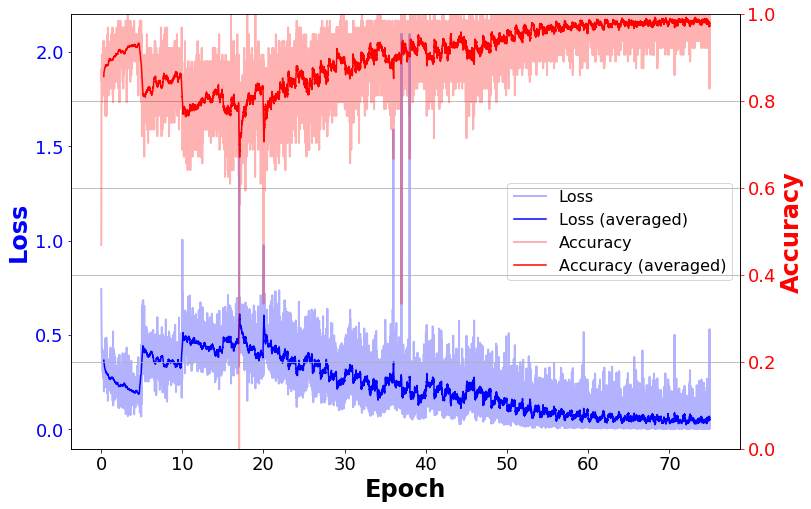

In [11]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

epoch    = moving_average(np.array(train_log.epoch),40)
accuracy = moving_average(np.array(train_log.accuracy),40)
loss     = moving_average(np.array(train_log.loss),40)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Loss', color='b', alpha=0.3)
line12 = ax1.plot(epoch, loss, label='Loss (averaged)', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Accuracy', color='r', alpha=0.3)
line22 = ax2.plot(epoch, accuracy, label='Accuracy (averaged)', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()


The tick lines now represent the moving average (all data points are from the train log). It appears the network is still learning. We can train for a longer period to achieve a better accuracy.

## Performance Analysis
Beyond looking at the performance of the network, we can analyze how the network is performing for each classification target. Let's first obtain a high-statistics analysis output by running the network on all test samples.

In [12]:
def inference(blob,data_loader):
    label,prediction,accuracy=[],[],[]
    # set the network to test (non-train) mode
    blob.net.eval()
    # create the result holder
    index,label,prediction = [],[],[]
    for i,data in enumerate(data_loader):
        blob.data, blob.label = data[0:2]
        res = forward(blob,True)
        accuracy.append(res['accuracy'])
        prediction.append(res['prediction'])
        label.append(blob.label)
        #if i==2: break
    # report accuracy
    accuracy   = np.array(accuracy,dtype=np.float32)
    label      = np.hstack(label)
    prediction = np.hstack(prediction)
    
    return accuracy, label, prediction

Let's run the inference using this function on the test sample, and look at the error matrix.

0 to 100 MeV
Accuracy mean 0.77524424 std 0.03188586


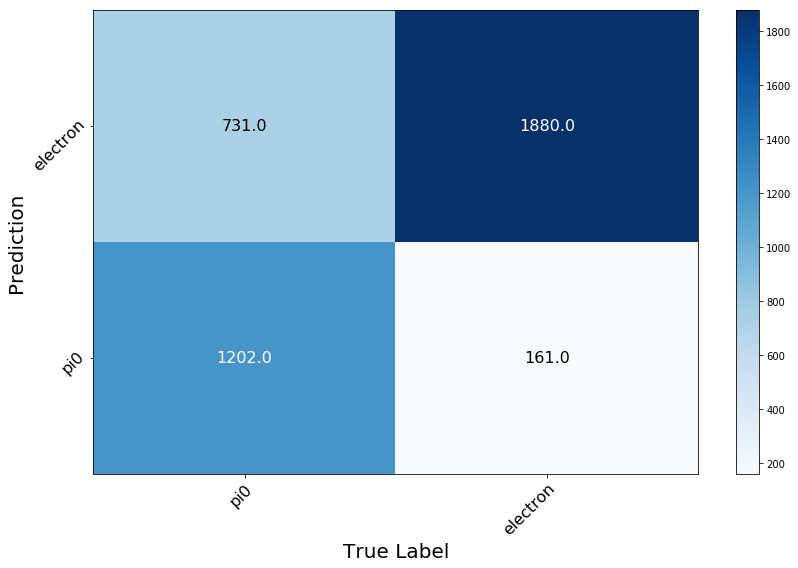

100 to 200 MeV
Accuracy mean 0.73285705 std 0.03227567


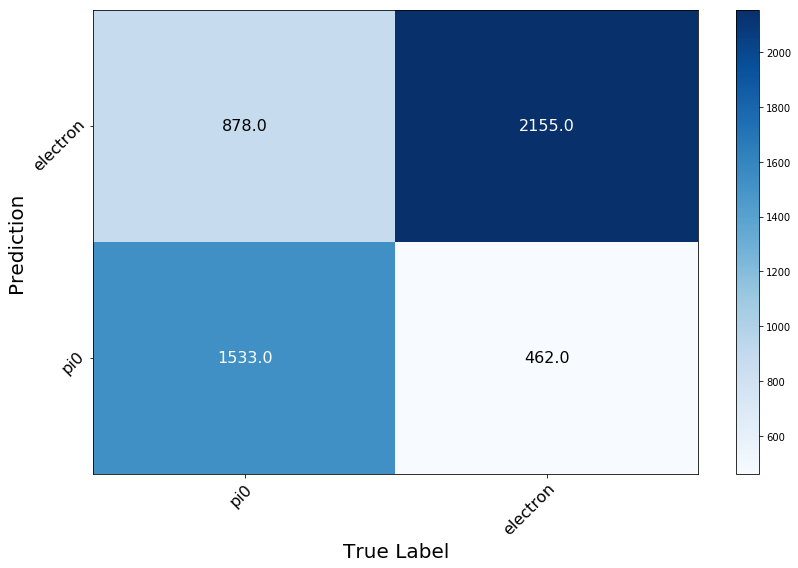

200 to 300 MeV
Accuracy mean 0.68540215 std 0.036863774


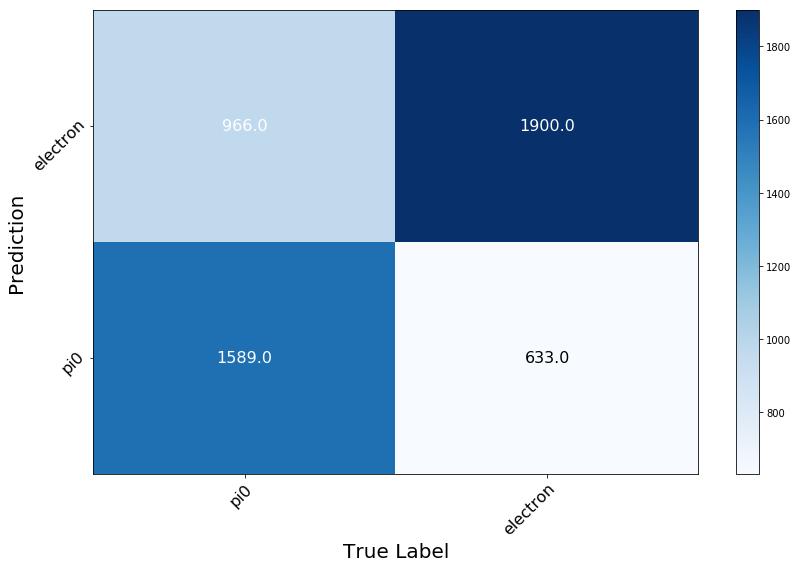

300 to 400 MeV
Accuracy mean 0.67631584 std 0.044640947


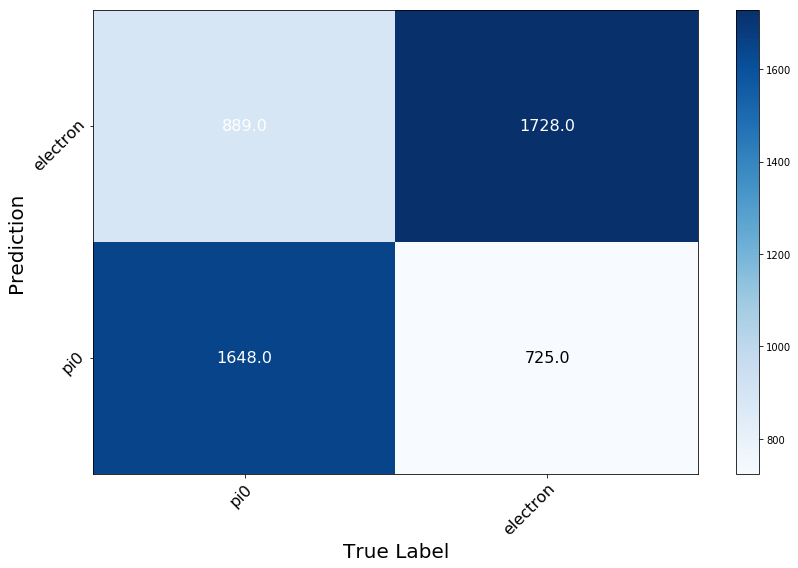

400 to 500 MeV
Accuracy mean 0.654686 std 0.03421156


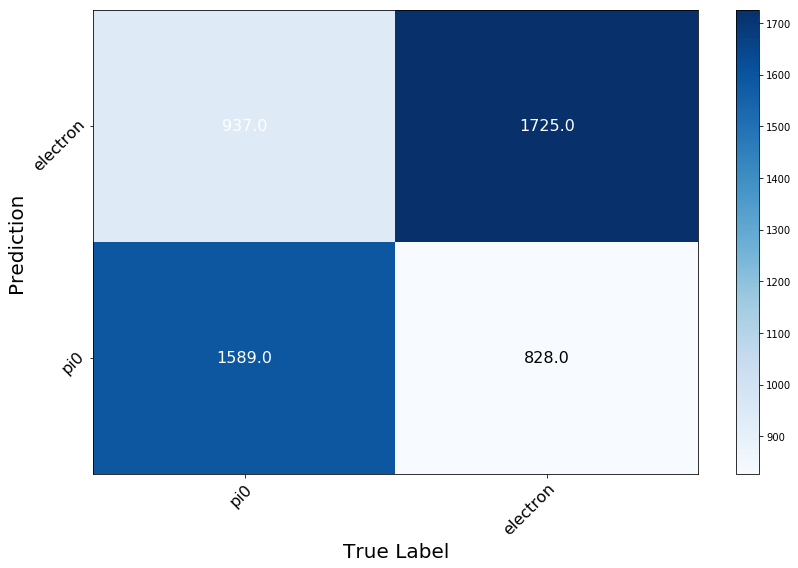

500 to 600 MeV
Accuracy mean 0.65168273 std 0.03609706


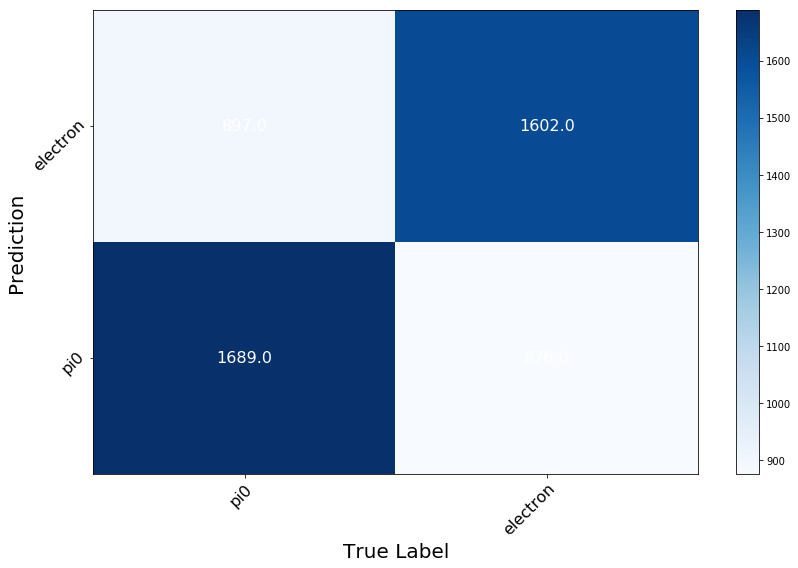

600 to 700 MeV
Accuracy mean 0.6284829 std 0.03098208


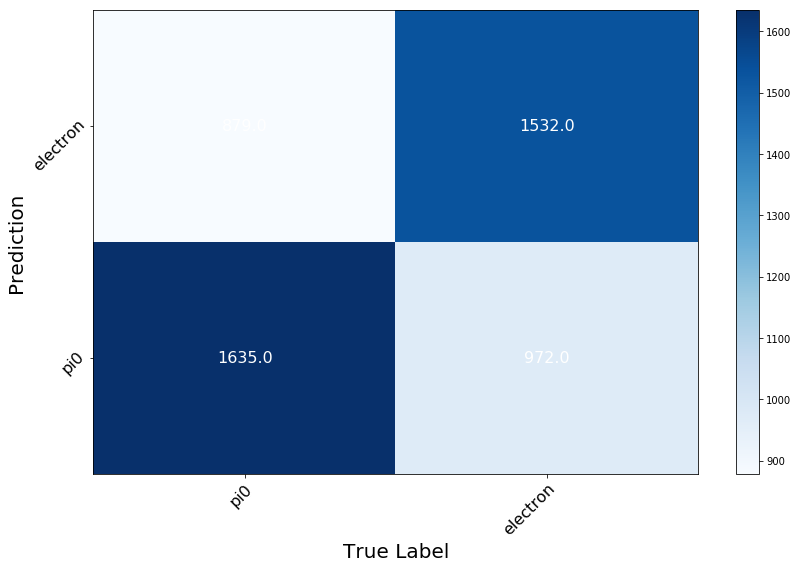

700 to 800 MeV
Accuracy mean 0.62538457 std 0.0337389


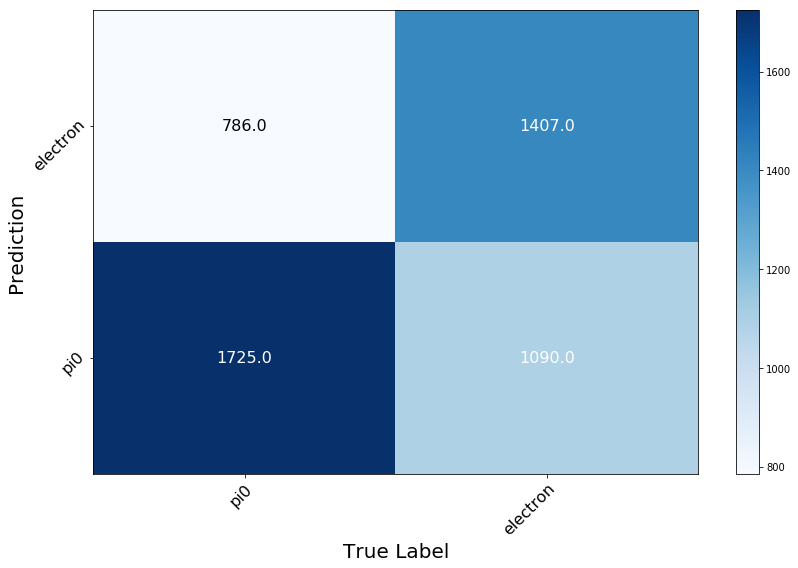

800 to 900 MeV
Accuracy mean 0.6082452 std 0.026308326


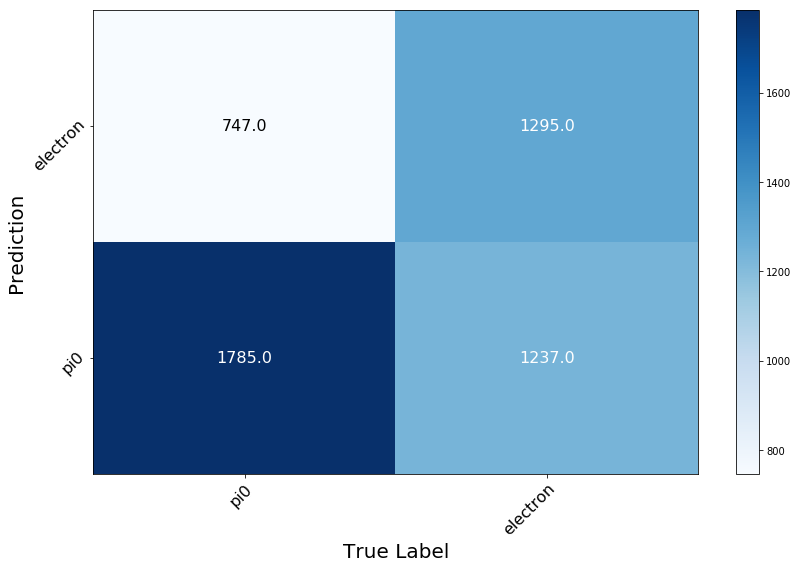

900 to 1000 MeV
Accuracy mean 0.58893055 std 0.038766492


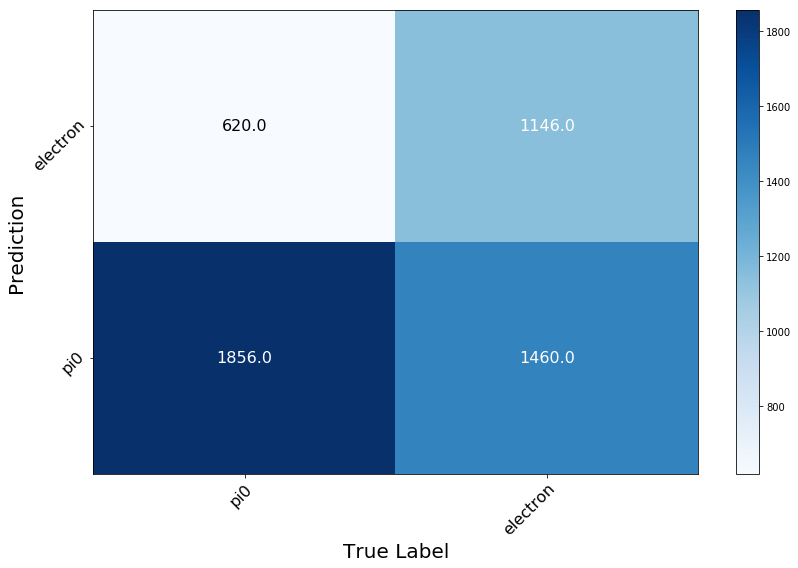

In [13]:
from utils import plot_confusion_matrix
accuracies = []
mins = []
maxs = []
for i in range(10):
    emin = i*100
    emax = (i+1)*100
    print(emin,"to",emax,"MeV")
    accuracy,label,prediction = inference(blob,test_loaders2[i])
    print('Accuracy mean',accuracy.mean(),'std',accuracy.std())
    plot_confusion_matrix(label,prediction,['pi0','electron'])
    accuracies += [accuracy.mean()]
    mins += [emin]
    maxs += [emax]


In [14]:
import matplotlib.pyplot

Text(0,0.5,'Accuracy')

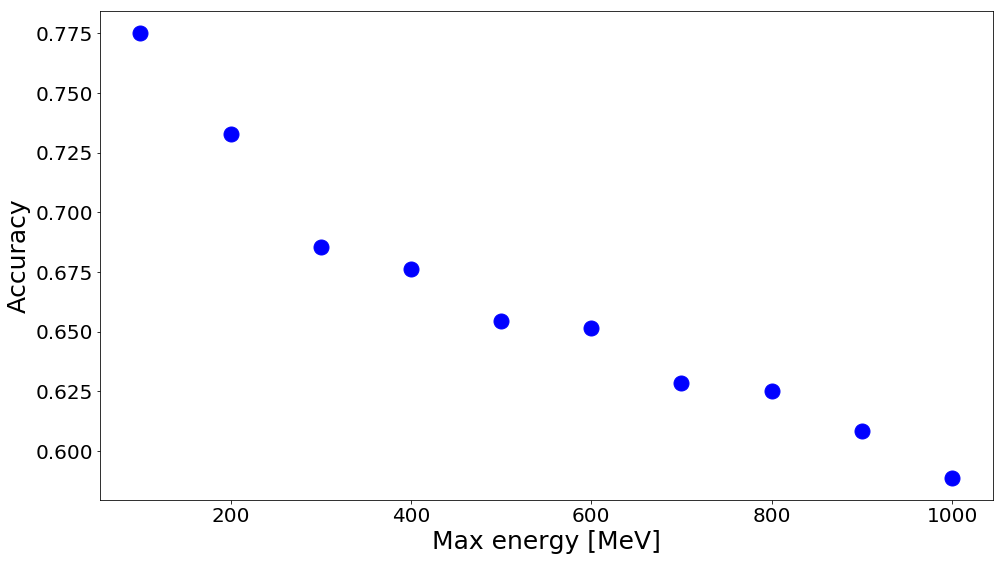

In [15]:
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.figure(figsize=(16,9))
plt.plot(maxs,accuracies, 'bo', markersize=15)
plt.xlabel('Max energy [MeV]', fontsize=25)
plt.ylabel('Accuracy', fontsize=25)

0 to 100 MeV
Accuracy mean 0.7756926 std 0.0312724


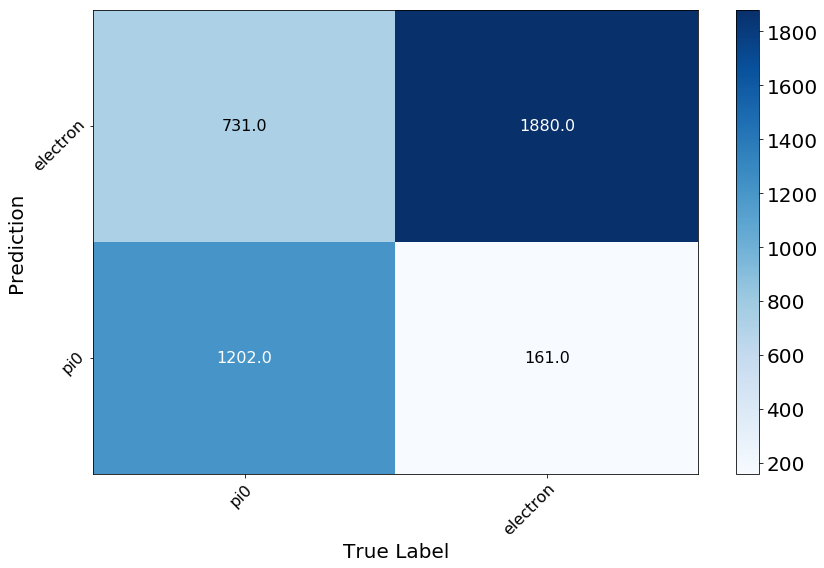

0 to 200 MeV
Accuracy mean 0.7466305 std 0.044466086


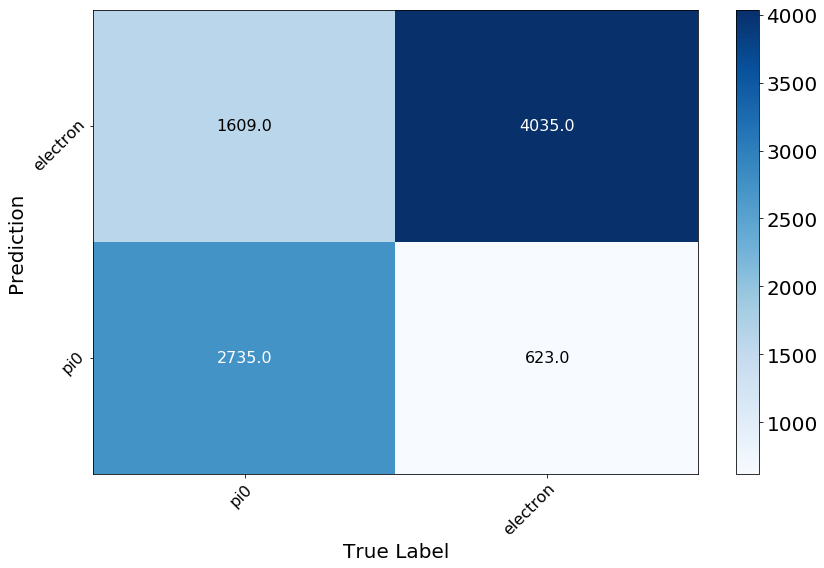

0 to 300 MeV
Accuracy mean 0.72814554 std 0.030648377


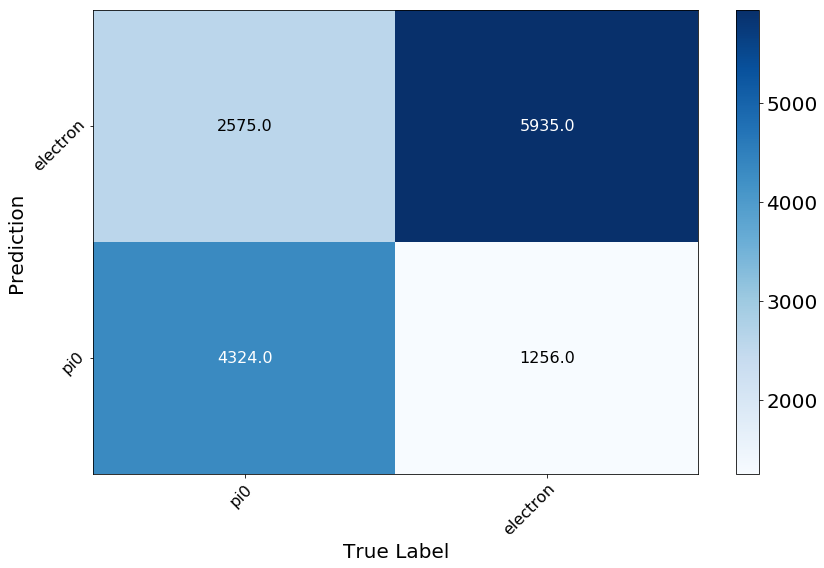

0 to 400 MeV
Accuracy mean 0.7146094 std 0.028287329


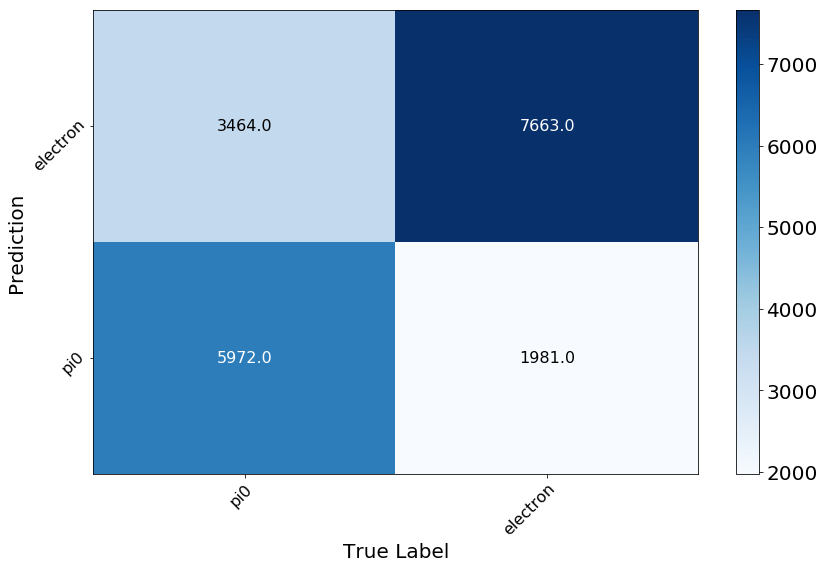

0 to 500 MeV
Accuracy mean 0.7016186 std 0.029029502


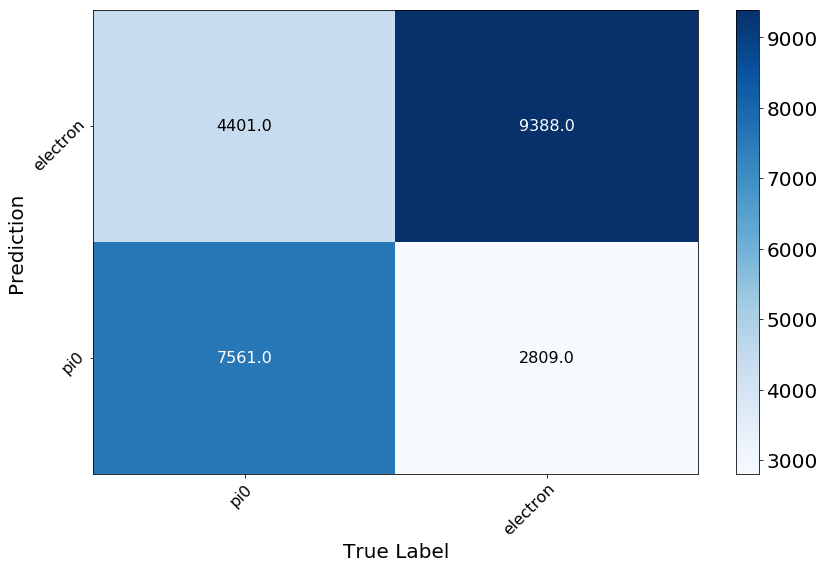

0 to 600 MeV
Accuracy mean 0.6926235 std 0.030569449


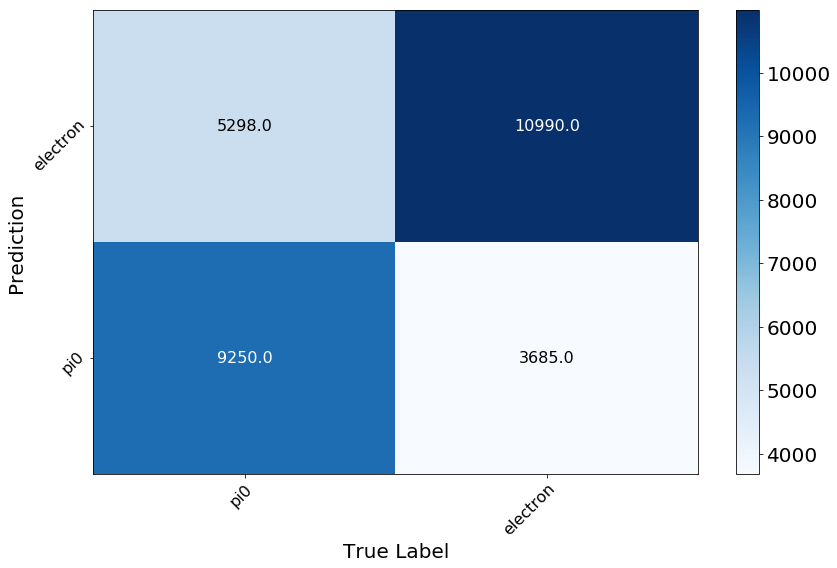

0 to 700 MeV
Accuracy mean 0.6838181 std 0.034086186


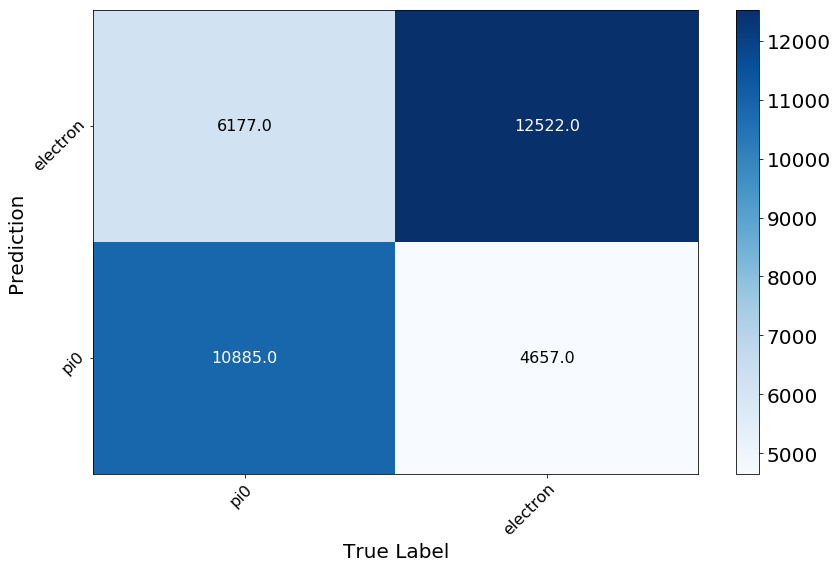

0 to 800 MeV
Accuracy mean 0.67623794 std 0.03356405


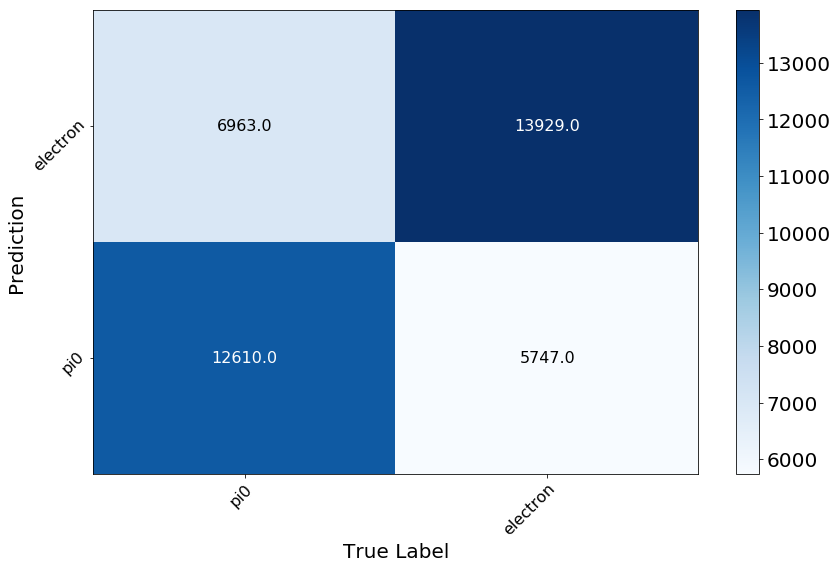

0 to 900 MeV
Accuracy mean 0.66830844 std 0.033701334


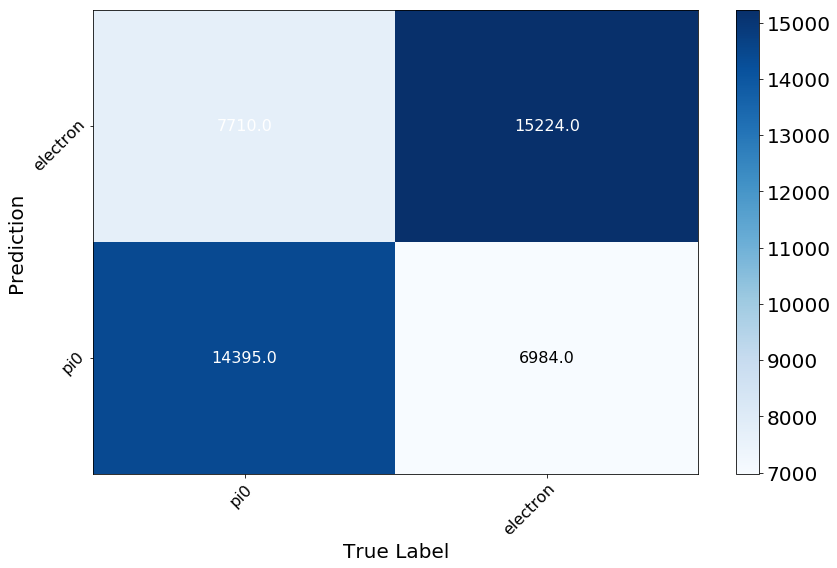

0 to 1000 MeV
Accuracy mean 0.6604147 std 0.03551723


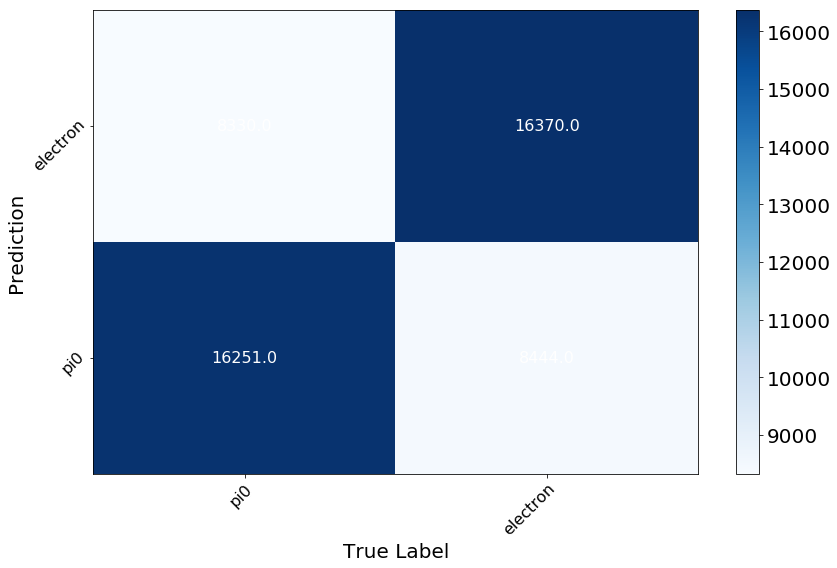

In [16]:
from utils import plot_confusion_matrix
accuracies2 = []
mins2 = []
maxs2 = []
for i in range(10):
    emin = 0
    emax = (i+1)*100
    print(emin,"to",emax,"MeV")
    accuracy,label,prediction = inference(blob,test_loaders[i])
    print('Accuracy mean',accuracy.mean(),'std',accuracy.std())
    plot_confusion_matrix(label,prediction,['pi0','electron'])
    accuracies2 += [accuracy.mean()]
    mins2 += [emin]
    maxs2 += [emax]


Text(0,0.5,'Accuracy')

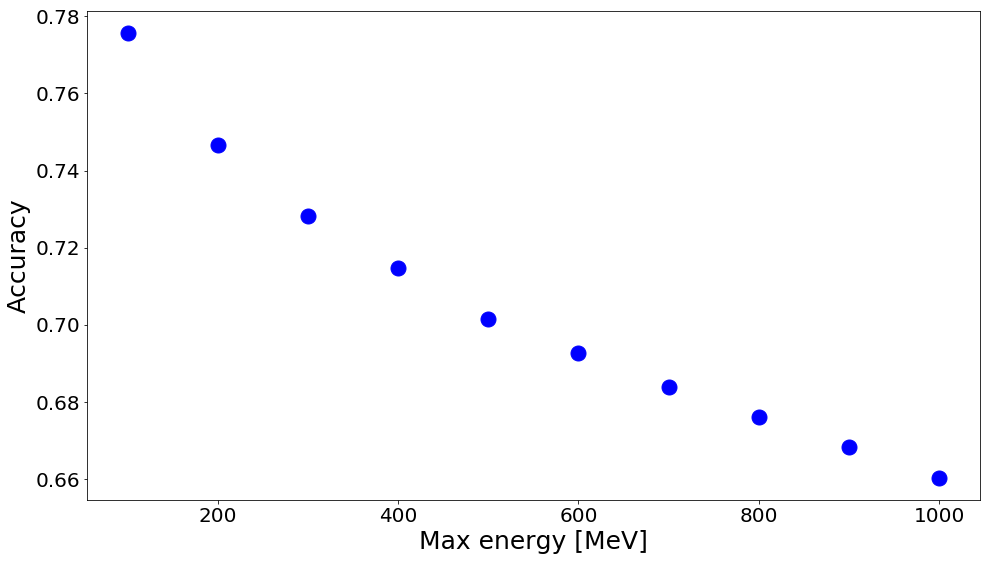

In [17]:
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.figure(figsize=(16,9))
plt.plot(maxs2,accuracies2, 'bo', markersize=15)
plt.xlabel('Max energy [MeV]', fontsize=25)
plt.ylabel('Accuracy', fontsize=25)